# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 01.10.2023

Мягкий дедлайн: 23:59MSK 15.10.2023

Жесткий дедлайн: 23:59MSK 20.10.2023

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Итогова оценка считается как
$$
min(task_1, task_2)*0.8 + max(task_1, task_2)*0.2
$$

где task_1 и task_2 - оценки за первое и второе заданиее соответсвенно.
Также, за домашнее задание выставляется 0, если не сделано нулевое или третье задание.
### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [4]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2023-10-16 20:28:16--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.txt.zip’

data.txt.zip            [             <=>    ] 201.24M  47.7MB/s    in 4.7s    

2023-10-16 20:28:21 (42.7 MB/s) - ‘data.txt.zip’ saved [211011981]



In [5]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Мы вывели кусок данных, чтобы понять, насколько они пригодны для работы без изменений. Здесь ясно, что сомнительно дальше с такими данными работать, потому что как минимум есть отрицательные значения, которые не отмасштабированы, кроме того еще сразу бросается в глаза совсем разная размерность, где-то видим реально большие числа, а где-то 0.075. Ясно, что будем скейлить.

In [6]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

Для выполнения данного задания (и всех последующих) предобработайте данные.

1. Зафиксируйте random_seed везде где только возможно. Вам предоставлена функция для этого, однако вы можете дополнить ее своими дополнениями
2. Обучите StandertScaler и предобработайте ваши данные. В следующих заданиях можете использовать другой scaler или вообще отказаться от него


In [7]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    # Add smth here if you need...

In [9]:
set_random_seed(42)

In [ ]:
ridge = Ridge(random_state=42)
ridge.fit(X_train, y_train)
model = ridge.predict(X_test)
rmse_for_model = np.sqrt(mean_squared_error(np.array(y_test), np.array(model)))
rmse_for_model

9.510160820470436

Лучшая константа для RMSE это среднее, посчитаем значение метрики при нем

In [ ]:
best_rmse_metric = np.full_like(y_test, np.mean(y_train))
rmse_for_model = np.sqrt(mean_squared_error(y_test, best_rmse_metric))
rmse_for_model #надеюсь, что поняла задание правильно

10.863228020678134

## Задание 1. (максимум 10 баллов)

Закрепите свои знания о том, как pytorch работает с обратным распространением ошибки, проделав следующие шаги:

1. Создайте модель линейной регрессии, которая будет состоять только из одного Linear слоя.
2. Напишите цикл обучения вашей линейной регрессии. В нем реализуйте подсчет функции потерь, сделайте шаг градиентного спуска. Запрещено использовать готовые оптимизаторы и loss-функции из библиотеки pytorch. Для подсчета градиента воспользуйтесь методом backward.
3. Запустите обучение на 10 эпохах, после каждой проверяйте значение целевой метрики на тестовой выборке.
4. Выведите на экран графики метрики и значения функции потерь на тестовой и обучающей выборке.

В данном задании нет цели побить какой-то порог по метрике. Ваша задача - убедиться в том, что ваш рукописный цикл обучения работает. Для ускорения вычислений и обучения модели можете брать только срез данных, а не весь датасет.

In [ ]:
!pip install wandb --upgrade --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 18.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.3 MB/s eta 0:00:00


In [ ]:
import wandb

In [ ]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:

# ⸂⸂⸜(രᴗര๑)⸝⸃⸃ Good luck!
set_random_seed(42)
X_train_tensor = torch.Tensor(X_train[:10000])
y_train_tensor = torch.Tensor(y_train[:10000])

X_test_tensor = torch.Tensor(X_test[:10000])
y_test_tensor = torch.Tensor(y_test[:10000])

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=1)
val_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=1)

In [ ]:
model = nn.Linear(X_train.shape[1], 1)
model.to(device)

# инициализируем проект
wandb.init(project="pytorch-demo")
# сохраняем параметры сетки в wandb + просим следить за градиентами сетки
wandb.watch(model);

wandb: Currently logged in as: nazgul-2003 (team_name_12). Use `wandb login --relogin` to force relogin


In [ ]:
lr = 0.001
# Списки для хранения метрик
train_losses = []
test_losses = []
for epoch in range(10):
    val_loss_train = []  # сюда будем складывать **средний по бачу** лосс по train
    for x_tr, y_tr in tqdm(train_dataloader):  # берем батч из трейн лоадера
        y_pred = model(x_tr.to(device))  # делаем предсказания
        loss = torch.mean((y_pred - y_tr.to(device)) ** 2) # считаем лосс
        val_loss_train.append(loss.detach().cpu().numpy()) # добавляем в массив
        loss.backward()  # считаем градиенты обратным проходом
        with torch.no_grad():
            for param in model.parameters():
                param.data -= lr * param.grad
        model.zero_grad()#обнуляем градиенты

    val_loss_test = []  # сюда будем складывать **средний по бачу** лосс
    with torch.no_grad():  # на валидации запрещаем фреймворку считать градиенты по параметрам
        for x_val, y_val in tqdm(
            val_dataloader
        ):  # берем батч из валидационного лоадера
            y_pred = model(x_val.to(device))  # делаем предсказания
            loss = torch.mean((y_pred - y_val.to(device)) ** 2)
            val_loss_test.append(loss.cpu().numpy())  # добавляем в массив

    # скидываем метрики на wandb и автоматом смотрим на графики
    wandb.log(
        {
            "mean val loss train": np.mean(val_loss_train),
            "mean val loss test": np.mean(val_loss_test),
        }
    )

    train_losses.append(np.mean(val_loss_train))
    test_losses.append(np.mean(val_loss_test))

    # печатаем метрики
    print(
        f"Epoch: {epoch}, loss train: {np.mean(val_loss_train)}, loss test: {np.mean(val_loss_test)}"
    )

print("\n", model)

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 0, loss train: 1469965.875, loss test: 343302.09375


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 1, loss train: 125159.171875, loss test: 32690.515625


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 2, loss train: 12064.2578125, loss test: 3920.554443359375


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 3, loss train: 1654.74755859375, loss test: 827.07861328125


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 4, loss train: 480.7468566894531, loss test: 352.57269287109375


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 5, loss train: 261.6632385253906, loss test: 226.93772888183594


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 6, loss train: 189.6622772216797, loss test: 177.90248107910156


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 7, loss train: 155.16302490234375, loss test: 155.09588623046875


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 8, loss train: 137.0509033203125, loss test: 141.3038330078125


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 9, loss train: 125.79859924316406, loss test: 134.8155975341797

 Linear(in_features=90, out_features=1, bias=True)


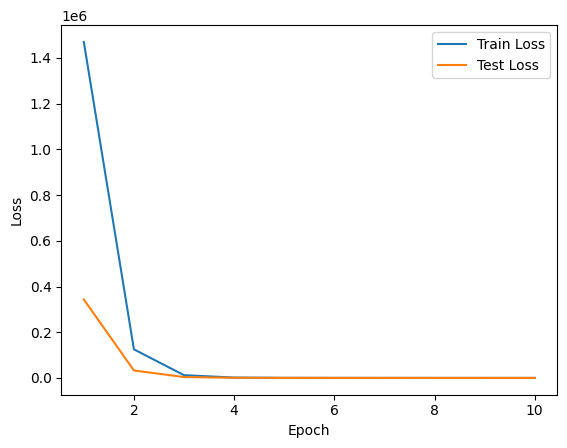

In [ ]:
#график
plt.plot(range(1, 11), train_losses, label="Train Loss")
plt.plot(range(1, 11), test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
#тут поптыка написать линейную регрессию вручную
set_random_seed(42)
w = torch.rand(X_train.shape[1],1, requires_grad=True)
b = torch.rand(1, requires_grad=True)

In [ ]:
lr = 0.001
train_losses = []
test_losses = []
for epoch in range(10):
    val_loss_train = []  # сюда будем складывать **средний по бачу** лосс по train
    for x_tr, y_tr in tqdm(train_dataloader):  # берем батч из трейн лоадера
        y_pred = torch.mm(x_tr.cpu(), w) + b
        loss = torch.mean((y_pred - y_tr.cpu()) ** 2) # считаем лосс
        val_loss_train.append(loss.detach().cpu().numpy()) # добавляем в массив
        loss.backward()  # считаем градиенты обратным проходом
        # делаем шаг градиентного спуска с lr
        w.data -= lr * w.grad
        b.data -= lr * b.grad

        # обнуляем градиенты, чтобы на следующем шаге опять посчитать и не аккумулировать их
        w.grad.data.zero_()
        b.grad.data.zero_()

    val_loss_test = []  # сюда будем складывать **средний по бачу** лосс
    with torch.no_grad():  # на валидации запрещаем фреймворку считать градиенты по параметрам
        for x_val, y_val in tqdm(
            val_dataloader
        ):  # берем батч из валидационного лоадера
            y_pred =torch.mm(x_val.cpu(), w) + b  # делаем предсказания
            loss = torch.mean((y_pred - y_val.cpu()) ** 2)
            val_loss_test.append(loss.cpu().numpy())  # добавляем в массив

    # скидываем метрики на wandb и автоматом смотрим на графики
    wandb.log(
        {
            "mean val loss train": np.mean(val_loss_train),
            "mean val loss test": np.mean(val_loss_test),
        }
    )

    train_losses.append(np.mean(val_loss_train))
    test_losses.append(np.mean(val_loss_test))

    # печатаем метрики
    print(
        f"Epoch: {epoch}, loss train: {np.mean(val_loss_train)}, loss test: {np.mean(val_loss_test)}"
    )

print("\n", model)

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 0, loss train: 1469085.0, loss test: 343183.0625


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 1, loss train: 125107.625, loss test: 32693.490234375


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 2, loss train: 12066.025390625, loss test: 3926.647216796875


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 3, loss train: 1657.82763671875, loss test: 829.9205322265625


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 4, loss train: 482.5685119628906, loss test: 353.8311767578125


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 5, loss train: 262.5542907714844, loss test: 227.55079650878906


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 6, loss train: 190.14923095703125, loss test: 178.20765686035156


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 7, loss train: 155.439453125, loss test: 155.29934692382812


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 8, loss train: 137.22972106933594, loss test: 141.4322509765625


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 9, loss train: 125.9251480102539, loss test: 134.93115234375

 Linear(in_features=90, out_features=1, bias=True)


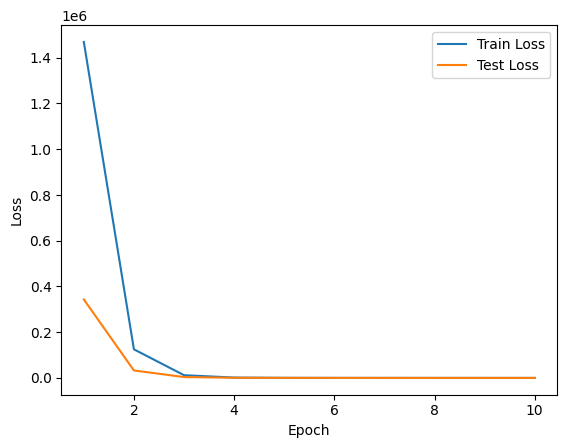

In [ ]:
#график
plt.plot(range(1, 11), train_losses, label="Train Loss")
plt.plot(range(1, 11), test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Задание 2. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из предыдущего задания.



Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться сигнатурами функций, которые приведены ниже. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [10]:
set_random_seed(42)
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)

X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)

#для нормализации таргета
mean_target = y_train_tensor.mean()
std_target = y_train_tensor.std()

X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train).view(-1, 1)
y_train_normalized = (y_train_tensor - mean_target) / std_target

X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test).view(-1, 1)
y_test_normalized = (y_test_tensor - mean_target) / std_target

train_dataset = TensorDataset(X_train_tensor, y_train_normalized)
test_dataset = TensorDataset(X_test_tensor, y_test_normalized)

In [21]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

model = nn.Sequential(nn.BatchNorm1d(X_train.shape[1]),
                      nn.Linear(X_train.shape[1], 64),
                      nn.ReLU(),
                      #nn.Dropout(0.3),
                      nn.Linear(64,64),
                      nn.ReLU(),
                      #nn.Dropout(0.5),
                      nn.Linear(64,1))
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)
criterion = nn.MSELoss()
model.to((device))

Sequential(
  (0): BatchNorm1d(90, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Linear(in_features=90, out_features=64, bias=True)
  (2): ReLU()
  (3): Linear(in_features=64, out_features=64, bias=True)
  (4): ReLU()
  (5): Linear(in_features=64, out_features=1, bias=True)
)

In [15]:
def train(model, optimizer, criterion, train_dataloader, val_dataloader, n_epochs=5, wandb_project=None):
    """
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    """
    # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
    # подключаем wandb
    if wandb_project:
        import wandb
        wandb.init(project=wandb_project)
        wandb.watch(model)
    train_losses = []
    test_losses = []
    for epoch in range(1,n_epochs+1):
        # тренировка
        train_loss = []
        model.train()
        for x_tr, y_tr in tqdm(train_dataloader):
            y_pred = model(x_tr.to(device))
            loss = criterion(y_pred, y_tr.to(device))
            train_loss.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # валидация
        model.eval()
        if epoch % 2 == 0:
          val_loss = []
          # отключается весь функционал расчета градиентов
          with torch.no_grad():
              for x_val, y_val in tqdm(val_dataloader):
                  y_pred = model(x_val.to(device))
                  y_pred_unnormalized = (y_pred * std_target) + mean_target
                  y_val_unnormalized = (y_val.to(device) * std_target) + mean_target
                  loss = criterion(y_pred_unnormalized, y_val_unnormalized)
                  val_loss.append(loss.item())

          if wandb_project:
              # скидываем метрики на wandb и автоматом смотрим на графики
              wandb.log(
                  {
                      "mean val rmse train": np.sqrt(np.mean(train_loss)),
                      "mean val rmse test": np.sqrt(np.mean(val_loss)),
                  }
              )

          train_losses.append(np.sqrt(np.mean(train_loss)))
          test_losses.append(np.sqrt(np.mean(val_loss)))

          # печатаем метрики
          # печатаем метрики
          print(
              f"Epoch: {epoch}, mse train: {np.mean(train_loss)}, rmse test: {np.sqrt(np.mean(val_loss))}"
          )
    return train_losses, test_losses
    #raise NotImplementedError

def test(model, criterion, val_dataloader):
    """
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    """
    # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
    model.eval()  # переводим модель в режим оценки (тестирования)
    predicts = []

    # отключается весь функционал расчета градиентов
    with torch.no_grad():
        for x_val, y_val in tqdm(val_dataloader):
            y_pred = model(x_val.to(device))
            predicts.extend(y_pred.cpu().numpy())
            #loss = criterion(y_pred, y_val)
    predicts = torch.ones(len(val_dataloader.dataset))
    return predicts


In [ ]:
assert test(model, criterion, val_dataloader).shape[0] == y_test.shape[0]

  0%|          | 0/3227 [00:00<?, ?it/s]

In [22]:
set_random_seed(42)
train_losses, test_losses = train(model, optimizer, criterion, train_dataloader, val_dataloader, n_epochs=26)

predictions = test(model, criterion, val_dataloader)

  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 2, mse train: 0.6757318035360367, rmse test: 8.940492901225644


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 4, mse train: 0.6520301282298917, rmse test: 8.862664103723088


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 6, mse train: 0.6420522042990487, rmse test: 8.858148393453604


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 8, mse train: 0.6354332541131262, rmse test: 8.848927848744474


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 10, mse train: 0.6307525745958805, rmse test: 8.799895177750338


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 12, mse train: 0.6270481882102247, rmse test: 8.806532615267214


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 14, mse train: 0.6231658620327473, rmse test: 8.80588389444973


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 16, mse train: 0.6215909835410782, rmse test: 8.806954675947532


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 18, mse train: 0.6189507242932756, rmse test: 8.788262426252363


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 20, mse train: 0.6172801117882392, rmse test: 8.823163086097908


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 22, mse train: 0.6154707032850919, rmse test: 8.803269659251152


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 24, mse train: 0.6137877744377038, rmse test: 8.805241898888555


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 26, mse train: 0.6124188384314186, rmse test: 8.771870634018414


  0%|          | 0/807 [00:00<?, ?it/s]

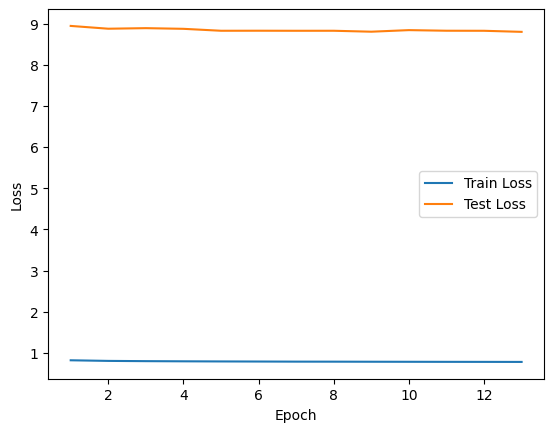

In [19]:
plt.plot(range(1, 14), train_losses, label="Train Loss")
plt.plot(range(1, 14 ), test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Задание 3. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

Во-первых, попыталась сделать то же самое, что делала в первом задании с batch_size = 16 и lr = 0.001.
Во-вторых, пробовала sgd с моментумом, но качество тоже было не очень.
В-третьих, нормализовала таргет.
В-четвертых, использовала Adam со schedular.
Получилось выбить качество на 4. Дальше не получилось из-за того, что колаб тупил.
Возможно, под конец заданных эпох получится добиться результата на 6.